# Eval and Function Analysis

### Background Information
In JavaScript, there are 2 methods a programmer can use to dynamically create a function using a string. The first is by calling the ```eval()``` function and the second is by creating a ```new Function()``` object and then calling that function object.  

For example:

```javascript
eval("console.log('hello')")

var my_func = new Function("console.log('hello')")
my_func()
```

will print hello twice.

For simplicity we will refer to using eval, rather than both eval and new Function, in this analysis.  Just note that both methods work similarly and pose similar problems to security and privacy.

Using eval is generally considered bad practice as is opens developers code to injection attacks such as cross-site scripting attacks. Additionally eval can be used to hide malicious code written by web developers. Since the function calls are generated dynamically static code analysis techniques and manual inspection are less effective at identifying malicious code.  Finally, while not the focus of this analysis, there are issues with the performance of code generated with eval that make it a bad choice in general coding circumstances.

Because eval is generally considered a bad practice, we examine webpages that use eval, in order to better understand the prevalence of eval in the web and how it is being used inside the webpages that decide to use eval.

We base the majority of the analysis on a single sample of 10,000 random webpages. We also take 10 smaller samples of 5,000 webpages that is used to look for sampling biases in the analysis.

#### This notebook looks at 8 aspects of the "script_loc_eval" row in the crawl dataset:
1. What % of webpages use eval atleast once.
2. The number of unique scripts that use eval.
3. Out of the scripts on webpages that use eval, how many scripts are 3rd party scripts.
4. Summary statistics about the # of eval calls per webpage.
5. For all the webpages that use eval at least once, How many times is eval used by these webpages and what % of total function calls are eval calls.
6. A visualization of the distribution of the # of eval calls.
7. A visualization of the distribution of the % of function calls for a webpage that are created using eval.
8. A visualization of the relationship between the # of eval calls and the % of function calls that are created using eval.

#### Through this analysis we found that:
1. ~9% of webpages use eval at least once. This observation is consistent between multiple samples as there is little variance.
2. ~50% of scripts that use eval are unique and those scripts are part of a small number of domain entities.
3. ~66% of scripts are hosted on 3rd party domains.
4. Webpages tend to only have 1-3 function calls created using eval. However some webpages use eval significantly more often.
5. Webpages tend to either have all of their function calls created using eval, or a few functions created using eval.
6. There is no correlation between the # of eval calls and the % of function calls that are created using eval.

In [1]:
import sys
sys.path.append('..')

import logging
import matplotlib.pyplot as plt
import pandas as pd
import sample_data

from utils import load_data_util

%matplotlib inline

In [2]:
%%time
# prevent printing of validation warning messages for cleaner output
logging.getLogger("validator").setLevel(logging.ERROR)

files_to_analyze = 10000
data = load_data_util.load_random_data(files_to_analyze, False, 42, False)

Wall time: 26min 27s


#### Get 10 samples of 5000 webpages so we can analyze how our analysis differs between different samples.

In [3]:
%%time
# prevent printing of validation warning messages for cleaner output
logging.getLogger("validator").setLevel(logging.ERROR)

samples_files_to_analyze = 5000
seeds = [-12, 0, 90, 6258, 73, 1111, 20000, 7512, 2222, 4567]
samples = [
    load_data_util.load_random_data(samples_files_to_analyze, False, seed, False, False) 
    for seed in seeds
]


Wall time: 20min 10s


#### Define a helper function to get the top level domain from a url using the [disconnectme](https://github.com/disconnectme/disconnect-tracking-protection) entity list.

In [187]:
# retrieve the entity list from github and store it in a json object.
entity_list = sample_data.make_entity_list_df()

def get_top_level_domain_entity(url):
    """Returns the domain entity that the url belongs to if it can be found in the disconnectme entity list. 
    If the url cannot be found in the entity list then the empty string is returned. 
    url -- a url for a webpage. Ex. "https://github.com/issues"
    """
    for index, row in entity_list.iterrows():
        for site in row["resources"]:
            match_found = sample_data.find_url_match(url, site)
            if match_found and match_found != "IrregularUrl":
                return row.name
            elif match_found == "IrregularUrl":
                # Not possible to find match for irregular url, so return.
                return ""

    # no match could be found to return the url.
    return ""

## Process the data by building a dictionary with webpage urls as keys and eval information as the values.

In [188]:
def process_results(data_frame):
    """Processes the data retrieved from S3. Returns a JSON object with webpage urls 
    as keys and the processed results as values.
    data_frame -- A Pandas DataFrame that contains S3 JSON data from multiple webpages.
    """
    result = {}
    for index, row in data_frame.iterrows():
        # get the url of the webpage that was being crawled and use thafat as a unique key.
        key = row['location']

        if key not in result:
            result[key] = {
                "domain entity": get_top_level_domain_entity(key),
                "count": 0,
                "total_func_calls": 0,
                "script_urls": {}
            }

        if row['script_loc_eval'] != "":
            result[key]["count"] += 1

            script_url = row['script_url']
            result[key]["script_urls"][script_url] = result[key]["script_urls"].get(script_url, 1) + 1
        result[key]["total_func_calls"] += 1
        
    return result

In [189]:
result = process_results(data)

In [190]:
sample_results = [process_results(sample_data) for sample_data in samples]

## Analyze the collected data to get:
* The number of webpages with atleast 1 eval call.
* The number of scripts that use eval and have a different domain name than the webpage calling that script.
* The number of scripts that use eval and are not hosted on the same domain entity as the webpage calling that script.
* A list with all the scripts that have functions created using eval.
* A DataFrame with the url for webpages that have 1 or more function created using eval. The DataFrame contains the # of eval calls for that webpage and the % of function calls that were created using eval.

In [191]:
class EvalAnalyzer:
    """Analyzes data from processed webpage data and stores the analysis for later use.
    """
    def __init__(self, result):
        """Initializes the objects variables, along with Analyzing the 
        result object and storing that analysis data for later use.
        result -- JSON object with processed S3 webpage data.
        """
        self.webpages_with_eval_calls = 0
        self.external_script_count = 0
        self.external_domain_entity_count = 0
        self.script_urls = []
        self.webpages_analyzed = len(result)
        self.eval_usage = pd.DataFrame(columns=['url', '# of eval calls', '% of eval calls'])
        
        self.analyze(result)
        
    def analyze(self, result):
        """Analyzes the result object and stores the analysis data in member variables for later use.
        result -- JSON object with processed S3 webpage data.
        """
        for key in result:
            if result[key]['count'] > 0:
                self.webpages_with_eval_calls += 1

                self.eval_call_count = result[key]['count']
                self.eval_call_percent = round(result[key]['count'] / result[key]['total_func_calls'] * 100, 2)

                self.eval_usage = self.eval_usage.append({
                    "url": key,
                    "# of eval calls": self.eval_call_count,
                    "% of eval calls": self.eval_call_percent
                }, ignore_index=True)

                for script_url in result[key]["script_urls"]:
                    self.script_urls.append(script_url)

                    location_domain_entity = result[key]["domain entity"] if result[key]["domain entity"] != "" else key
                    script_domain_entity = get_top_level_domain_entity(script_url)
                    
                    if (location_domain_entity != script_domain_entity) and (not sample_data.find_url_match(key, script_url)):
                        self.external_domain_entity_count += 1
                    if not sample_data.find_url_match(key, script_url):
                        self.external_script_count += 1

        # set '# of eval calls' to be int type since it was being set to object type.
        # without this change later analysis and visualizations do not work.
        self.eval_usage['# of eval calls'] = self.eval_usage['# of eval calls'].astype("int")

In [192]:
analysis = EvalAnalyzer(result)

In [193]:
sample_analyses = [EvalAnalyzer(sample) for sample in sample_results]

irregular script_url:  data:text/javascript,eval(mod_pagespeed_bdXcYBOsVm)%3B
irregular script_url:  data:text/javascript,eval(mod_pagespeed_kd38%24NxVpB)%3B
irregular script_url:  data:text/javascript,eval(mod_pagespeed_sgVXYq9OQ3)%3B
irregular script_url:  data:text/javascript,eval(mod_pagespeed_qv6weZiEH4)%3B
irregular script_url:  data:text/javascript,eval(mod_pagespeed_6N23NffyO4)%3B


## Examine the % of webpages that have 1 or more function created using eval.

Before doing further analysis we want to see how prevalent eval is on the web.

In [194]:
def get_percentage_of_webpages_with_eval_calls(analysis):
    """Returns the percentage of total webpages in the analysis that have 1 or more eval call.
    analysis -- EvalAnalysis object created by analyzing multiple webpages.
    """
    return round(analysis.webpages_with_eval_calls / analysis.webpages_analyzed * 100, 2)

def print_percentage_of_webpages_with_eval_calls(analysis):
    """Prints the % and number of webpages with 1 or more eval call.
    analysis -- EvalAnalysis object created by analyzing multiple webpages.
    """
    percentage_of_webpages_with_eval_calls = get_percentage_of_webpages_with_eval_calls(analysis)

    print(
        str(percentage_of_webpages_with_eval_calls) + "% (" + 
        str(analysis.webpages_with_eval_calls) + "/" + str(analysis.webpages_analyzed) + 
        ") of webpages have 1 or more function that is created using eval."
    )

#### Display information for our single, large dataset. 

In [195]:
print_percentage_of_webpages_with_eval_calls(analysis)

8.92% (890/9972) of webpages have 1 or more function that is created using eval.


#### Display information for our multiple smaller samples and compare it with the larger sample.

In [196]:
percentage_of_eval_webpages_with_eval_calls_in_samples = pd.Series([
    get_percentage_of_webpages_with_eval_calls(analysis) 
    for analysis in sample_analyses
])

sample_percent_mean = round(percentage_of_eval_webpages_with_eval_calls_in_samples.mean(), 2)
sample_percent_difference = abs(get_percentage_of_webpages_with_eval_calls(analysis) - sample_percent_mean)
sample_percent_variance = round(percentage_of_eval_webpages_with_eval_calls_in_samples.var(), 2)
sample_percent_standard_deviation = round(percentage_of_eval_webpages_with_eval_calls_in_samples.std(), 2)
    
print(str(sample_percent_mean) + "% is the mean % of webpages with 1 or more function created using eval.")
print(str(sample_percent_difference) + 
    "% is the difference between our single large sample and the mean of multiple smaller samples."
)
print(str(sample_percent_variance) + "% is the variance of the % of webpages with 1 or more function created using eval.")
print(str(sample_percent_standard_deviation) + 
    "% is the standard deviation of the % of webpages with 1 or more function created using eval."
)

8.67% is the mean % of webpages with 1 or more function created using eval.
0.25% is the difference between our single large sample and the mean of multiple smaller samples.
0.15% is the variance of the % of webpages with 1 or more function created using eval.
0.38% is the standard deviation of the % of webpages with 1 or more function created using eval.


We can see that ~9% of webpages use eval and that the number of webpages using eval does not change much between samples.  This shows that while a majority of webpages do not use eval at all, a significant number of webpages still do make use of eval. Thus we continue our analysis to see how eval is being used on these webpages that use eval.

## Examine what % of the scripts that use eval are unique.

Next we want to see if all of the functions that use eval are located on the same scripts, or different scripts. We accomplish this by examining how many unique script urls are in the script url list created earlier. We also look at script urls that are part of a one of the disconnectme domain entities and how many of those are unique.

In [197]:
def get_percentage(numerator, denominator):
    """Returns the percentage value of the numerator divided by the denominator, rounded to 2 decimal places.  
    numerator -- the top value in a percentage calculation.
    denominator -- the bottom value in a percentage calculation.
    """
    return round(numerator / denominator * 100, 2)

def get_number_of_script_urls(analysis):
    """Returns the number of script urls in the anaylsis.
    analysis -- EvalAnalysis object created by analyzing multiple webpages.
    """
    return len(analysis.script_urls)

def get_number_of_unique_script_urls(analysis):
    """Returns the number of unique script urls in the analysis.
    analysis -- EvalAnalysis object created by analyzing multiple webpages.
    """
    unique_script_urls = set(analysis.script_urls)
    return len(unique_script_urls)

def get_script_domain_entities(analysis):
    """Returns a list of the top level domain entities for each script urls in the analysis.
    The top level domain and retrieved from the disconnectme entity list.
    analysis -- EvalAnalysis object created by analyzing multiple webpages.
    """
    script_domain_entities = []
    
    for url in set(analysis.script_urls):
        domain_entity = get_top_level_domain_entity(url)
        if domain_entity != "":
            script_domain_entities.append(domain_entity)
            
    return script_domain_entities

def get_number_of_script_domain_entities(script_domain_entities):
    """Returns the number of script domain entities in the array.
    script_domain_entities -- an array with domain entity values in it retrieved from the disconnectme entity list.
    """
    return len(script_domain_entities)

def get_number_of_unique_script_domain_entities(script_domain_entities):
    """Returns the number of unique script domain entities in the array.
    script_domain_entities -- an array with domain entity values in it retrieved from the disconnectme entity list.
    """
    unique_script_domain_entities = set(script_domain_entities)
    return len(unique_script_domain_entities)

In [198]:
number_of_script_urls = get_number_of_script_urls(analysis)
number_of_unique_script_urls = get_number_of_unique_script_urls(analysis)

script_domain_entities = get_script_domain_entities(analysis)

number_of_script_domain_entities = get_number_of_script_domain_entities(script_domain_entities)        
number_of_unique_script_domain_entities = get_number_of_unique_script_domain_entities(script_domain_entities)

# calculate the percentages
percentage_of_unique_script_urls = get_percentage(number_of_unique_script_urls, number_of_script_urls)
percentage_of_script_domain_entities = get_percentage(number_of_script_domain_entities, number_of_unique_script_urls)
percentage_of_unqiue_script_domain_entities = get_percentage(
    number_of_unique_script_domain_entities, 
    number_of_script_domain_entities
)

In [210]:
print(str(number_of_script_urls) + " scripts contain a function call that is created using eval in this sample.")

print(
    str(percentage_of_unique_script_urls) + "% (" + 
    str(number_of_unique_script_urls) + "/" + str(number_of_script_urls) + 
    ") of the scripts that use eval are unique."
)

print(
    str(percentage_of_script_domain_entities) + "% (" + 
    str(number_of_script_domain_entities) + "/" + str(number_of_unique_script_urls) + 
    ") of those unqique scripts are part of a domain entity in the disconnectme entity list."
)

print(
    str(percentage_of_unqiue_script_domain_entities) + "% (" + 
    str(number_of_unique_script_domain_entities) + "/" + str(number_of_script_domain_entities) + 
    ") of those domain entities are unique."
)


1000 scripts contain a function call that is created using eval in this sample.
55.1% (551/1000) of the scripts that use eval are unique.
41.74% (230/551) of those unqique scripts are part of a domain entity in the disconnectme entity list.
10.43% (24/230) of those domain entities are unique.


We observe that around half of scripts that use eval are unique.  This indicates that while eval usage is overly spread out between different script urls, it is also not clustered in a few scripts that host the majority of eval usage.

Only ~40% of the unique script urls could be found in the disconnectme list.  This indicates that the majority of script urls that use eval are not hosted on common web tracker domains.

When duplicates are removed from the list of domain entities we can see that only 24 domain entities are left.  This indicates that the list of actual trackers that use eval is small.

In [200]:
mean_number_of_script_urls = pd.Series([
        get_number_of_script_urls(sample_analysis) 
        for sample_analysis in sample_analyses
]).mean()

# get the # and % of script urls that are unique
mean_number_of_unique_script_urls = pd.Series([
        get_number_of_unique_script_urls(sample_analysis) 
        for sample_analysis in sample_analyses 
]).mean()

mean_percentage_of_unique_script_urls = round(pd.Series([
        get_percentage(get_number_of_unique_script_urls(sample_analysis), get_number_of_script_urls(sample_analysis))
        for sample_analysis in sample_analyses 
]).mean(), 2)

# get a list of script domain entities to be used for later calculations
sample_script_domain_entities = [
        get_script_domain_entities(sample_analysis)
        for sample_analysis in sample_analyses 
]

# get the mean # and % of script urls that correspond to a domain entity
mean_number_of_script_domain_entities = pd.Series([
        get_number_of_script_domain_entities(domain_entity)
        for domain_entity in sample_script_domain_entities
]).mean()

mean_percentage_of_script_domain_entities = round(pd.Series([
        get_percentage(
            get_number_of_script_domain_entities(domain_entity),
            mean_number_of_unique_script_urls
        )
        for domain_entity in sample_script_domain_entities
]).mean(), 2)



# get the mean # and % of script urls that correspond to a unique domain entity
mean_number_of_unique_script_domain_entities = pd.Series([
        get_number_of_unique_script_domain_entities(domain_entity)
        for domain_entity in sample_script_domain_entities
]).mean()

mean_percentage_of_unique_script_domain_entities = round(pd.Series([
        get_percentage(
            get_number_of_unique_script_domain_entities(domain_entity), 
            get_number_of_script_domain_entities(domain_entity)
        )
        for domain_entity in sample_script_domain_entities
]).mean(), 2)


irregular script_url:  data:text/javascript,eval(mod_pagespeed_kd38%24NxVpB)%3B
irregular script_url:  data:text/javascript,eval(mod_pagespeed_6N23NffyO4)%3B
irregular script_url:  data:text/javascript,eval(mod_pagespeed_qv6weZiEH4)%3B
irregular script_url:  data:text/javascript,eval(mod_pagespeed_bdXcYBOsVm)%3B
irregular script_url:  data:text/javascript,eval(mod_pagespeed_sgVXYq9OQ3)%3B


In [201]:
print(str(mean_number_of_script_urls) + " is the mean number of function calls created using eval in the samples.")

print(
    str(mean_percentage_of_unique_script_urls) + "% (" + 
    str(mean_number_of_unique_script_urls) + "/" + str(mean_number_of_script_urls) + 
    ") is the mean number of unique script urls in the sample."
)

print(
    str(mean_percentage_of_script_domain_entities) + "% (" + 
    str(mean_number_of_script_domain_entities) + "/" + str(mean_number_of_unique_script_urls) + 
    ") is the mean number of domain entities in the unique script urls for our samples."
)

print(
    str(mean_percentage_of_unique_script_domain_entities) + "% (" + 
    str(mean_number_of_unique_script_domain_entities) + "/" + str(mean_number_of_script_domain_entities) + 
    ") is the mean number of unique domain entities."
)

487.1 is the mean number of function calls created using eval in the samples.
62.97% (306.8/487.1) is the mean number of unique script urls in the sample.
38.92% (119.4/306.8) is the mean number of domain entities in the unique script urls for our samples.
16.61% (19.8/119.4) is the mean number of unique domain entities.


The number of function calls, unique scripts, and domain entities are similar to what we would expect based on the earlier sample. The number of unique domain entities however only decreases by 4, despite the samples looking at half as many webpages.  This indicates that a small number of domain entities are hosting the scripts that use eval, and that those same trackers are present even in smaller sample sizes.

## Examine the number of scripts that are hosted on a 3rd parties domain.

Next we want to see if scripts that use eval are hosted externally. This can show us whether webpages are knowingly using eval in their own code, or if they are using someone else's scripts which use eval, likely without the webpage developers knowledge.

In [202]:
total_script_urls = len(analysis.script_urls)
percentage_of_external_scripts = round(analysis.external_script_count / total_script_urls * 100, 2)

print(
    str(percentage_of_external_scripts) + "% (" + 
    str(analysis.external_script_count) + "/" + str(total_script_urls) + 
    ") of scripts that use eval are hosted on a different domain than the source webpage."
)


percentage_of_external_domain_entity_scripts = round(analysis.external_domain_entity_count / total_script_urls * 100, 2)
print(
    str(percentage_of_external_domain_entity_scripts) + "% (" + 
    str(analysis.external_domain_entity_count) + "/" + str(total_script_urls) + 
    ") of scripts that use eval are part of a different domain entity than the webpage," + 
    " or have a different domain name than the source webpage."
)

67.7% (677/1000) of scripts that use eval are hosted on a different domain than the source webpage.
52.0% (520/1000) of scripts that use eval are part of a different domain entity than the webpage, or have a different domain name than the source webpage.


Around two thirds of scripts are hosted on a different domain than the webpage that calls the script and even when looking at domain entities only ~50% of scripts are hosted on the same domain entity, or domain, as the webpage.

## Print summary statistics for # of eval calls

In [203]:
standard_deviation = round(analysis.eval_usage['# of eval calls'].std(), 2)
mean = round(analysis.eval_usage['# of eval calls'].mean(), 2)
median = round(analysis.eval_usage['# of eval calls'].median(), 2)

print('median = ' + str(median))
print('standard deviation = ' + str(standard_deviation))
print('average = ' + str(mean))

median = 3.0
standard deviation = 85.91
average = 19.84


The median number of eval calls is low, indicating that most webpages have few eval calls on them.  Since the standard deviation is large we can see that there is a some outliers that have a large number of eval calls.

## Display the number of eval calls and % of function calls that are created using eval for all the webpages with 1 or more eval calls.

To get a top level view of the out large sample we display all the webpages with the number of eval calls on them and % of total function calls that are created using eval.

In [204]:
print(analysis.eval_usage.sort_values(by=['# of eval calls'], ascending=False))

                                                   url  # of eval calls  % of eval calls
653        https://www.rezultati.com/nogomet/portugal/             1213            90.66
857  https://www.flashscore.pl/pilka-nozna/honduras...             1074            91.95
672  https://www.canliskor3.com/futbol/avrupa/sampi...              994            92.47
452  https://www.flashscore.com/soccer/netherlands/...              876            86.48
820  https://www.mismarcadores.com/futbol/espana/la...              833            88.43
839         https://www.soccerstand.com/soccer/uganda/              600            84.63
515    http://www.marksandspencer.com/l/lingerie/socks              427            54.95
854  https://particuliers.lcl.fr/quotidien/gestion-...              412            74.91
292          https://www.myscore.com.ua/football/peru/              360            82.57
864           https://www.flashscore.com/soccer/world/              348            81.50
333    https://www.me

## Visualize how many webpages have a given number of eval calls.

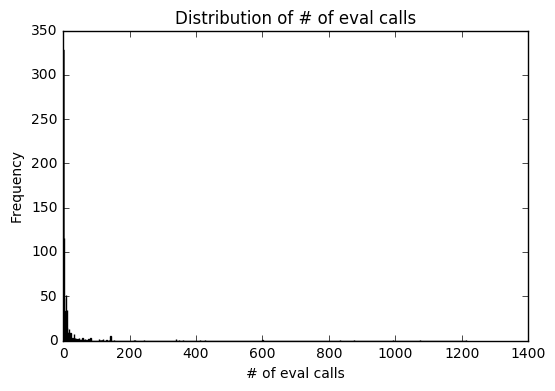

In [205]:
largest_eval_call_count = analysis.eval_usage['# of eval calls'].max()
plt.figure()

fig = analysis.eval_usage['# of eval calls'].plot.hist(bins=largest_eval_call_count)

plt.title("Distribution of # of eval calls")
fig.set_xlabel("# of eval calls")

plt.show()
plt.close()

Since the number of eval calls are so spread out, we cannot see much from the above graph other than that the majority of webpages have a low number of eval calls.  Thus, to better visualize the data, we create a second histogram that looks at the frequency of webpages where the number of eval calls is 2 standard deviations above 0. Since a large number of webpages only have 1 eval call, we use a log scale so that all the data can be seen.

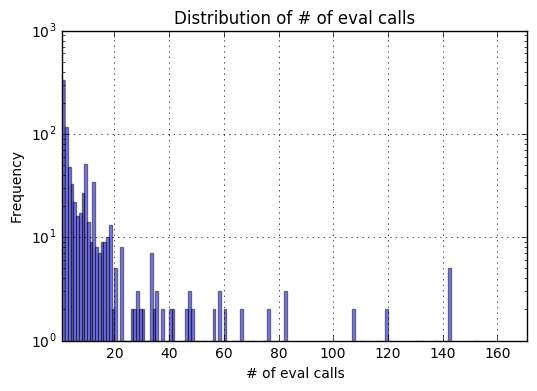

In [206]:
plt.figure()

fig = analysis.eval_usage['# of eval calls'].plot.hist(alpha=0.5, bins=largest_eval_call_count)

plt.title("Distribution of # of eval calls")
fig.set_xlabel("# of eval calls")
plt.yscale('log')
fig.set_xlim(1, int(standard_deviation * 2))
fig.grid()

plt.show()
plt.close()

Since the standard deviation is large we look at the first 1/4th of a standard deviation of eval calls to better visualize the histogram bins.

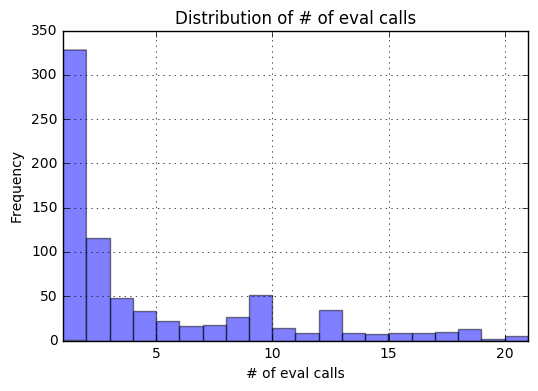

In [207]:
plt.figure()

fig = analysis.eval_usage['# of eval calls'].plot.hist(alpha=0.5, bins=largest_eval_call_count)

plt.title("Distribution of # of eval calls")
fig.set_xlabel("# of eval calls")
fig.set_xlim(1, int(standard_deviation / 4))
fig.grid();

plt.show()
plt.close()

We can now see that most webpages only make 1 or 2 eval calls.

## Visualize the distribution of the % of function calls, created using eval, that the webpages make.

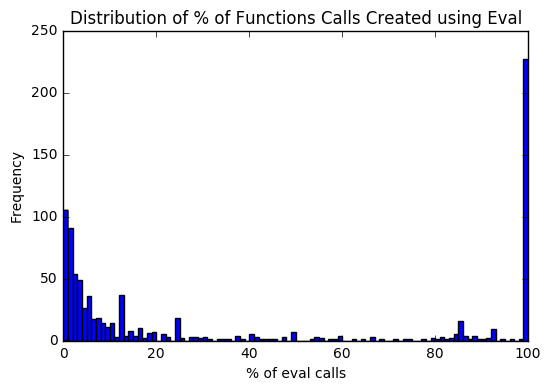

In [208]:
plt.figure()

fig = analysis.eval_usage['% of eval calls'].plot.hist(bins=100)

plt.title("Distribution of % of Functions Calls Created using Eval")
fig.set_xlabel("% of eval calls")

plt.show()
plt.close()

This shows that most webpages either have a few of their function calls created using eval, or all of the functions created using eval.

## Visualize the relationship between the number of eval calls and the % of functions on the webpage that are created using eval.

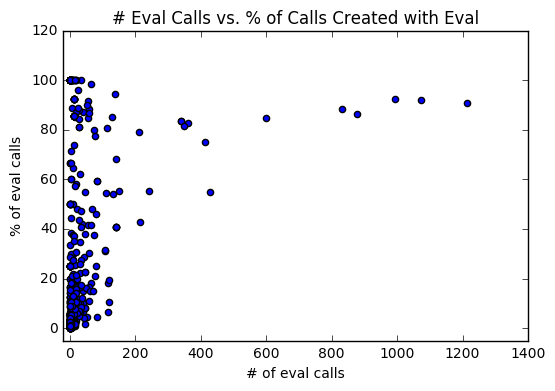

In [209]:
plt.figure()

fig = analysis.eval_usage.plot.scatter(x='# of eval calls', y='% of eval calls');

plt.title("# Eval Calls vs. % of Calls Created with Eval")
# set the x and y bounds so that they are slightly less than 1 so that the dots can be seen better.
fig.set_xlim(-20)
fig.set_ylim(-5)

plt.show()
plt.close()

The above graph shows that there is a low correlation between the # of eval calls and % of total calls created using eval.